# DVS Gesture SNN (Derrick Lee) — Multi-Bit Post-Training Quantization

This notebook applies **post-training quantization** at multiple bit-widths (8-bit, 3-bit, 2-bit) to the SNN architecture from `SNN_Tutorial_Derrick_Lee.ipynb`.

Pre-trained float32 weights are loaded from `snn_1.pth`.

**Workflow:**
1. Load pre-trained float32 SNN weights from `snn_1.pth`
2. Evaluate float32 baseline accuracy
3. **8-bit quantization** using PyTorch's built-in `torch.ao.quantization`
4. **3-bit quantization** using manual simulated quantization
5. **2-bit quantization** using manual simulated quantization
6. Compare all results

In [41]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.ao.quantization
import os
import copy

import snntorch as snn
from snntorch import surrogate
from snntorch import functional as SF
from snntorch import utils

import tonic
import tonic.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

In [42]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")
print(f"Note: Quantized inference will run on CPU (PyTorch quantization backend requirement)")

Device: cpu
Note: Quantized inference will run on CPU (PyTorch quantization backend requirement)


In [43]:
# Dataset Parameters (matching SNN_Tutorial_Derrick_Lee.ipynb)
sensor_size = tonic.datasets.DVSGesture.sensor_size

# Denoise + ToFrame with 25 time bins (same as Derrick Lee tutorial)
# Note: Downsampling from 128x128 -> 32x32 is done inline via
# nn.functional.interpolate() during forward pass, not in transforms
denoise_transform = transforms.Denoise(filter_time=10000)
frame_transform = transforms.ToFrame(sensor_size=sensor_size, n_time_bins=25)
all_transform = transforms.Compose([denoise_transform, frame_transform])

train_set = tonic.datasets.DVSGesture(save_to='./data', transform=all_transform, train=True)
test_set = tonic.datasets.DVSGesture(save_to='./data', transform=all_transform, train=False)

# Use DiskCachedDataset (same cache path as Derrick Lee tutorial)
cached_trainset = tonic.DiskCachedDataset(train_set, cache_path='./cache/dvsgesture/train')
cached_testset = tonic.DiskCachedDataset(test_set, cache_path='./cache/dvsgesture/test')

# DataLoaders (same batch sizes as Derrick Lee tutorial)
train_loader = DataLoader(cached_trainset, batch_size=64, shuffle=True, drop_last=True,
                          collate_fn=tonic.collation.PadTensors(batch_first=False))
test_loader = DataLoader(cached_testset, batch_size=32, shuffle=True, drop_last=True,
                         collate_fn=tonic.collation.PadTensors(batch_first=False))

# Inspect Data
for sample in iter(train_loader):
    print(f"Data shape (before interpolate): {sample[0].shape}")
    break

Data shape (before interpolate): torch.Size([25, 64, 2, 128, 128])


## Step 1: Define the SNN (Derrick Lee Architecture) and Load Weights from `snn_1.pth`

This is the same `nn.Sequential` architecture from the tutorial:
- `Conv2d(2, 12, 5)` → `MaxPool2d(2)` → Leaky LIF
- `Conv2d(12, 32, 5)` → `MaxPool2d(2)` → Leaky LIF
- `Flatten` → `Linear(800, 11)` → Leaky LIF (output)

Input is downsampled from 128×128 to 32×32 using `nn.functional.interpolate` (same as the tutorial training loop).

In [44]:
# Network parameters (same as Derrick Lee tutorial)
gradient = surrogate.fast_sigmoid(slope=25)
beta = 0.5

# Same nn.Sequential architecture
net = nn.Sequential(
    nn.Conv2d(2, 12, 5),
    nn.MaxPool2d(2),
    snn.Leaky(beta=beta, spike_grad=gradient, init_hidden=True),
    nn.Conv2d(12, 32, 5),
    nn.MaxPool2d(2),
    snn.Leaky(beta=beta, spike_grad=gradient, init_hidden=True),
    nn.Flatten(),
    nn.Linear(800, 11),
    snn.Leaky(beta=beta, spike_grad=gradient, init_hidden=True, output=True)
).to(device)

print(net)

Sequential(
  (0): Conv2d(2, 12, kernel_size=(5, 5), stride=(1, 1))
  (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (2): Leaky()
  (3): Conv2d(12, 32, kernel_size=(5, 5), stride=(1, 1))
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Leaky()
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=800, out_features=11, bias=True)
  (8): Leaky()
)


In [45]:
# Load pre-trained float32 weights from snn_1.pth
net.load_state_dict(torch.load('snn_1.pth', map_location=device))
net.eval()
print(f"Loaded pre-trained weights from snn_1.pth")
print(f"Float model size: {os.path.getsize('snn_1.pth') / 1024:.1f} KB")

Loaded pre-trained weights from snn_1.pth
Float model size: 80.2 KB


In [46]:
# Forward propagation function (same as Derrick Lee tutorial)
def forward_pass(model, data):
    spk_rec = []
    utils.reset(model)
    for step in range(data.size(0)):
        spk_out, mem_out = model(data[step])
        spk_rec.append(spk_out)
    return torch.stack(spk_rec)

In [47]:
# Reusable evaluation function
def evaluate_model(model, test_loader, device='cpu'):
    """Evaluate model accuracy on the test set."""
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, targets in test_loader:
            # Downsample from 128x128 to 32x32 (same as Derrick Lee tutorial)
            data = nn.functional.interpolate(data, size=(2, 32, 32))
            data = data.to(device)
            targets = targets.to(device)
            spk_rec = forward_pass(model, data)
            correct += SF.accuracy_rate(spk_rec, targets) * spk_rec.size(1)
            total += spk_rec.size(1)
    return (correct / total) * 100

## Step 2: Evaluate the Float32 Model (Baseline)

In [48]:
print("Evaluating Float32 Model (Baseline)...")
float_acc = evaluate_model(net, test_loader, device=device)
print(f"\n========== Float32 Test Accuracy: {float_acc:.2f}% ==========")

Evaluating Float32 Model (Baseline)...

========== Float32 Test Accuracy: 88.67% ==========


---
# Part A: 8-bit Quantization (PyTorch Built-in)

Uses `torch.ao.quantization` for proper INT8 post-training static quantization with observer calibration.

## Define the Quantizable SNN Wrapper

Each `QuantStub`/`DeQuantStub` instance is used **once** in the forward pass. LIF neurons run in float; Conv/Linear run in INT8.

In [49]:
class QuantizableSNN(nn.Module):
    """Quantizable version of the Derrick Lee SNN architecture."""
    def __init__(self):
        super(QuantizableSNN, self).__init__()

        self.quant_input = torch.ao.quantization.QuantStub()
        self.dequant1 = torch.ao.quantization.DeQuantStub()
        self.quant2 = torch.ao.quantization.QuantStub()
        self.dequant2 = torch.ao.quantization.DeQuantStub()
        self.quant3 = torch.ao.quantization.QuantStub()
        self.dequant3 = torch.ao.quantization.DeQuantStub()

        self.conv1 = nn.Conv2d(2, 12, 5)
        self.pool1 = nn.MaxPool2d(2)
        self.lif1 = snn.Leaky(beta=beta, spike_grad=gradient, init_hidden=True)

        self.conv2 = nn.Conv2d(12, 32, 5)
        self.pool2 = nn.MaxPool2d(2)
        self.lif2 = snn.Leaky(beta=beta, spike_grad=gradient, init_hidden=True)

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(800, 11)
        self.lif3 = snn.Leaky(beta=beta, spike_grad=gradient, init_hidden=True, output=True)

    def forward(self, x):
        x = self.quant_input(x)
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.dequant1(x)
        x = self.lif1(x)

        x = self.quant2(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.dequant2(x)
        x = self.lif2(x)

        x = self.quant3(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.dequant3(x)
        spk_out, mem_out = self.lif3(x)

        return spk_out, mem_out

print("QuantizableSNN defined.")

QuantizableSNN defined.


In [50]:
# Map nn.Sequential numeric keys to QuantizableSNN named keys
sequential_to_named = {
    '0': 'conv1', '2': 'lif1', '3': 'conv2',
    '5': 'lif2', '7': 'fc1', '8': 'lif3',
}

seq_state = torch.load('snn_1.pth', map_location='cpu')

new_state = {}
for key, value in seq_state.items():
    parts = key.split('.', 1)
    if parts[0] in sequential_to_named:
        new_key = sequential_to_named[parts[0]] + '.' + parts[1]
        new_state[new_key] = value

print(f"Mapped {len(new_state)} weight tensors")

Mapped 18 weight tensors


In [51]:
# 8-bit Quantization Pipeline
qnet_8bit = QuantizableSNN()
qnet_8bit.load_state_dict(new_state, strict=False)
qnet_8bit.eval()
qnet_8bit.to('cpu')

qnet_8bit.qconfig = torch.ao.quantization.get_default_qconfig('x86')
torch.ao.quantization.prepare(qnet_8bit, inplace=True)

# Calibrate
print("Calibrating 8-bit model...")
num_calib_batches = 10
with torch.no_grad():
    for batch_idx, (data, targets) in enumerate(train_loader):
        if batch_idx >= num_calib_batches:
            break
        data = nn.functional.interpolate(data, size=(2, 32, 32))
        data = data.to('cpu')
        utils.reset(qnet_8bit)
        for step in range(data.size(0)):
            qnet_8bit(data[step])
        print(f"  Batch {batch_idx+1}/{num_calib_batches}")

torch.ao.quantization.convert(qnet_8bit, inplace=True)
print("\n=== 8-bit Quantization Complete ===")

Calibrating 8-bit model...
  Batch 1/10
  Batch 2/10
  Batch 3/10
  Batch 4/10
  Batch 5/10
  Batch 6/10
  Batch 7/10
  Batch 8/10
  Batch 9/10
  Batch 10/10

=== 8-bit Quantization Complete ===


In [52]:
print("Evaluating 8-bit Quantized Model...")
acc_8bit = evaluate_model(qnet_8bit, test_loader, device='cpu')
print(f"\n========== 8-bit Test Accuracy: {acc_8bit:.2f}% ==========")

# Save and get size
torch.save(qnet_8bit.state_dict(), 'snn_1_quantized_int8.pth')
size_8bit = os.path.getsize('snn_1_quantized_int8.pth') / 1024
print(f"8-bit Model Size: {size_8bit:.1f} KB")

Evaluating 8-bit Quantized Model...

========== 8-bit Test Accuracy: 87.89% ==========
8-bit Model Size: 31.0 KB


---
# Part B: 3-bit and 2-bit Quantization (Simulated)

PyTorch's built-in quantization only supports 8-bit. For lower bit-widths, we use **simulated quantization**: weights are quantized to N bits by computing per-tensor scale/zero-point, rounding to integer, and dequantizing back to float32.

This simulates the accuracy degradation of lower-precision quantization while keeping the model runnable on standard hardware.

### How N-bit Quantization Works

For signed N-bit integers:
- Range: `[-2^(N-1), 2^(N-1) - 1]`
- 3-bit: `[-4, 3]` → 8 levels
- 2-bit: `[-2, 1]` → 4 levels

```
scale = (w_max - w_min) / (q_max - q_min)
zero_point = round(q_min - w_min / scale)
w_quantized = clamp(round(w / scale + zero_point), q_min, q_max)
w_dequantized = (w_quantized - zero_point) * scale
```

In [53]:
def quantize_tensor(tensor, num_bits):
    """Quantize a float tensor to N bits (symmetric signed quantization).
    
    Returns dequantized float tensor that simulates N-bit precision.
    """
    q_min = -(2 ** (num_bits - 1))
    q_max = (2 ** (num_bits - 1)) - 1
    
    # Symmetric quantization: scale based on max absolute value
    max_val = tensor.abs().max()
    if max_val == 0:
        return tensor
    
    scale = max_val / q_max
    
    # Quantize: float -> int
    q_tensor = torch.clamp(torch.round(tensor / scale), q_min, q_max)
    
    # Dequantize: int -> float (simulated)
    dq_tensor = q_tensor * scale
    
    return dq_tensor


def quantize_model_weights(model, num_bits):
    """Apply N-bit simulated quantization to all Conv2d and Linear weights.
    
    Creates a deep copy of the model and replaces weights with quantized versions.
    """
    q_model = copy.deepcopy(model)
    
    num_quantized = 0
    for name, module in q_model.named_modules():
        if isinstance(module, (nn.Conv2d, nn.Linear)):
            # Quantize weights
            with torch.no_grad():
                orig_weight = module.weight.data
                q_weight = quantize_tensor(orig_weight, num_bits)
                module.weight.data = q_weight
                
                # Quantize bias if present
                if module.bias is not None:
                    orig_bias = module.bias.data
                    q_bias = quantize_tensor(orig_bias, num_bits)
                    module.bias.data = q_bias
            
            num_quantized += 1
            print(f"  Quantized {name}: weight range [{q_weight.min():.4f}, {q_weight.max():.4f}]")
    
    print(f"\nQuantized {num_quantized} layers to {num_bits}-bit")
    return q_model

print("Quantization functions defined.")

Quantization functions defined.


---
## 3-bit Quantization

Signed 3-bit: 8 quantization levels `[-4, -3, -2, -1, 0, 1, 2, 3]`

In [54]:
print("=== 3-bit Quantization ===")
print("Quantizing weights to 3 bits (8 levels)...\n")

net_3bit = quantize_model_weights(net, num_bits=3)
net_3bit.to(device)
net_3bit.eval()

print("\nEvaluating 3-bit Model...")
acc_3bit = evaluate_model(net_3bit, test_loader, device=device)
print(f"\n========== 3-bit Test Accuracy: {acc_3bit:.2f}% ==========")

=== 3-bit Quantization ===
Quantizing weights to 3 bits (8 levels)...

  Quantized 0: weight range [-0.2895, 0.4343]
  Quantized 3: weight range [-1.0012, 0.6674]
  Quantized 7: weight range [-1.0274, 1.0274]

Quantized 3 layers to 3-bit

Evaluating 3-bit Model...

========== 3-bit Test Accuracy: 18.75% ==========


In [55]:
# Inspect 3-bit weight distributions
print("=== 3-bit Weight Analysis ===")
for name, module in net_3bit.named_modules():
    if isinstance(module, (nn.Conv2d, nn.Linear)):
        w = module.weight.data
        unique_vals = torch.unique(w)
        print(f"\n{name}:")
        print(f"  Unique weight values: {len(unique_vals)}")
        print(f"  Range: [{w.min():.4f}, {w.max():.4f}]")
        print(f"  Values: {unique_vals.numpy().round(4)}")

=== 3-bit Weight Analysis ===

0:
  Unique weight values: 6
  Range: [-0.2895, 0.4343]
  Values: [-0.2895 -0.1448  0.      0.1448  0.2895  0.4343]

3:
  Unique weight values: 6
  Range: [-1.0012, 0.6674]
  Values: [-1.0012 -0.6674 -0.3337 -0.      0.3337  0.6674]

7:
  Unique weight values: 7
  Range: [-1.0274, 1.0274]
  Values: [-1.0274 -0.6849 -0.3425 -0.      0.3425  0.6849  1.0274]


---
## 2-bit Quantization

Signed 2-bit: 4 quantization levels `[-2, -1, 0, 1]`

In [56]:
print("=== 2-bit Quantization ===")
print("Quantizing weights to 2 bits (4 levels)...\n")

net_2bit = quantize_model_weights(net, num_bits=2)
net_2bit.to(device)
net_2bit.eval()

print("\nEvaluating 2-bit Model...")
acc_2bit = evaluate_model(net_2bit, test_loader, device=device)
print(f"\n========== 2-bit Test Accuracy: {acc_2bit:.2f}% ==========")

=== 2-bit Quantization ===
Quantizing weights to 2 bits (4 levels)...

  Quantized 0: weight range [-0.4343, 0.4343]
  Quantized 3: weight range [-1.0012, 1.0012]
  Quantized 7: weight range [-1.0274, 1.0274]

Quantized 3 layers to 2-bit

Evaluating 2-bit Model...

========== 2-bit Test Accuracy: 8.59% ==========


In [57]:
# Inspect 2-bit weight distributions
print("=== 2-bit Weight Analysis ===")
for name, module in net_2bit.named_modules():
    if isinstance(module, (nn.Conv2d, nn.Linear)):
        w = module.weight.data
        unique_vals = torch.unique(w)
        print(f"\n{name}:")
        print(f"  Unique weight values: {len(unique_vals)}")
        print(f"  Range: [{w.min():.4f}, {w.max():.4f}]")
        print(f"  Values: {unique_vals.numpy().round(4)}")

=== 2-bit Weight Analysis ===

0:
  Unique weight values: 3
  Range: [-0.4343, 0.4343]
  Values: [-0.4343  0.      0.4343]

3:
  Unique weight values: 3
  Range: [-1.0012, 1.0012]
  Values: [-1.0012 -0.      1.0012]

7:
  Unique weight values: 3
  Range: [-1.0274, 1.0274]
  Values: [-1.0274  0.      1.0274]


---
# Final Comparison: Float32 vs 8-bit vs 3-bit vs 2-bit

In [58]:
# Model sizes
float_size = os.path.getsize('snn_1.pth') / 1024

# For simulated quantization, calculate theoretical compressed sizes
# Count total weight parameters
total_params = 0
for name, module in net.named_modules():
    if isinstance(module, (nn.Conv2d, nn.Linear)):
        total_params += module.weight.numel()
        if module.bias is not None:
            total_params += module.bias.numel()

# Theoretical sizes (params * bits / 8 bytes + overhead)
overhead_bytes = 1024  # approximate metadata overhead
size_3bit = (total_params * 3 / 8 + overhead_bytes) / 1024
size_2bit = (total_params * 2 / 8 + overhead_bytes) / 1024

print("=" * 70)
print("         Model Comparison: Float32 vs 8-bit vs 3-bit vs 2-bit")
print("         (Derrick Lee Architecture)")
print("=" * 70)
print(f"{'Metric':<25} {'Float32':>10} {'8-bit':>10} {'3-bit':>10} {'2-bit':>10}")
print("-" * 70)
print(f"{'Test Accuracy (%)':<25} {float_acc:>10.2f} {acc_8bit:>10.2f} {acc_3bit:>10.2f} {acc_2bit:>10.2f}")
print(f"{'Accuracy Drop (%)':<25} {'—':>10} {(float_acc - acc_8bit):>10.2f} {(float_acc - acc_3bit):>10.2f} {(float_acc - acc_2bit):>10.2f}")
print(f"{'Model Size (KB)':<25} {float_size:>10.1f} {size_8bit:>10.1f} {size_3bit:>10.1f} {size_2bit:>10.1f}")
print(f"{'Compression Ratio':<25} {'1.0x':>10} {float_size/size_8bit:>9.1f}x {float_size/size_3bit:>9.1f}x {float_size/size_2bit:>9.1f}x")
print(f"{'Quantization Levels':<25} {'~16.7M':>10} {'256':>10} {'8':>10} {'4':>10}")
print("=" * 70)

         Model Comparison: Float32 vs 8-bit vs 3-bit vs 2-bit
         (Derrick Lee Architecture)
Metric                       Float32      8-bit      3-bit      2-bit
----------------------------------------------------------------------
Test Accuracy (%)              88.67      87.89      18.75       8.59
Accuracy Drop (%)                  —       0.78      69.92      80.08
Model Size (KB)                 80.2       31.0        8.0        5.7
Compression Ratio               1.0x       2.6x      10.1x      14.2x
Quantization Levels           ~16.7M        256          8          4


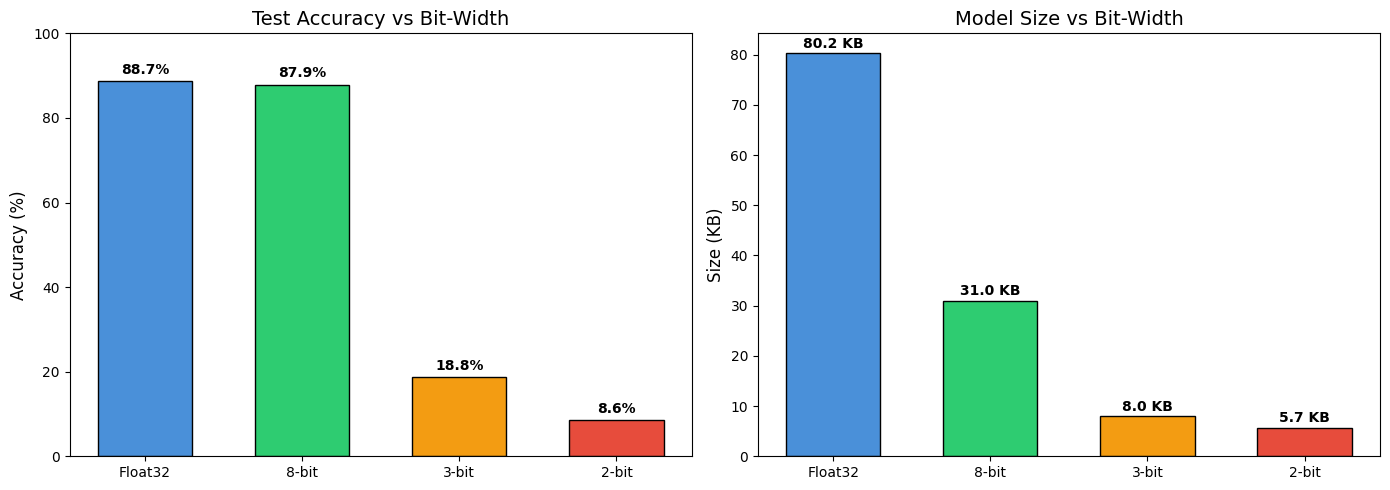

In [59]:
# Visual comparison
labels = ['Float32', '8-bit', '3-bit', '2-bit']
accuracies = [float_acc, acc_8bit, acc_3bit, acc_2bit]
sizes = [float_size, size_8bit, size_3bit, size_2bit]
colors = ['#4A90D9', '#2ECC71', '#F39C12', '#E74C3C']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy comparison
bars1 = ax1.bar(labels, accuracies, color=colors, width=0.6, edgecolor='black')
ax1.set_ylabel('Accuracy (%)', fontsize=12)
ax1.set_title('Test Accuracy vs Bit-Width', fontsize=14)
ax1.set_ylim(0, 100)
for bar, val in zip(bars1, accuracies):
    ax1.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 1, 
             f'{val:.1f}%', ha='center', va='bottom', fontweight='bold')

# Size comparison
bars2 = ax2.bar(labels, sizes, color=colors, width=0.6, edgecolor='black')
ax2.set_ylabel('Size (KB)', fontsize=12)
ax2.set_title('Model Size vs Bit-Width', fontsize=14)
for bar, val in zip(bars2, sizes):
    ax2.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.5, 
             f'{val:.1f} KB', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

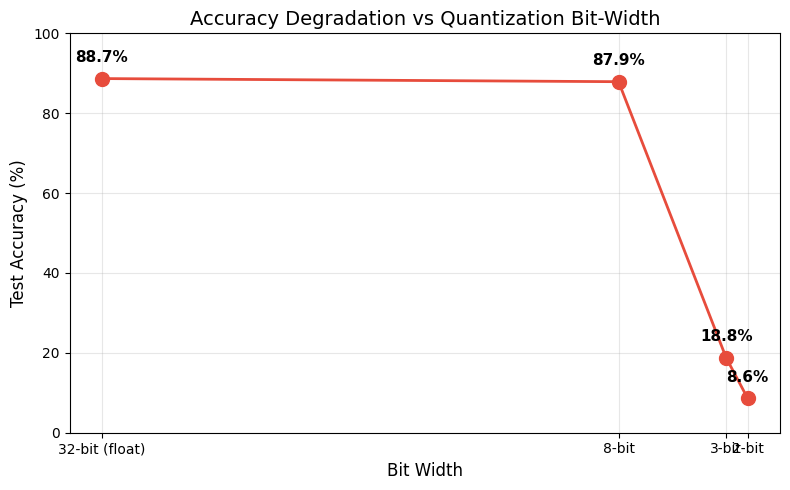

In [60]:
# Accuracy vs Bit-Width curve
bit_widths = [32, 8, 3, 2]

fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(bit_widths, accuracies, 'o-', color='#E74C3C', linewidth=2, markersize=10)

for bw, acc in zip(bit_widths, accuracies):
    ax.annotate(f'{acc:.1f}%', (bw, acc), textcoords='offset points',
                xytext=(0, 12), ha='center', fontweight='bold', fontsize=11)

ax.set_xlabel('Bit Width', fontsize=12)
ax.set_ylabel('Test Accuracy (%)', fontsize=12)
ax.set_title('Accuracy Degradation vs Quantization Bit-Width', fontsize=14)
ax.set_xticks(bit_widths)
ax.set_xticklabels(['2-bit', '3-bit', '8-bit', '32-bit (float)'][::-1])
ax.set_ylim(0, 100)
ax.grid(True, alpha=0.3)
ax.invert_xaxis()

plt.tight_layout()
plt.show()